In [1]:
import numpy as np
import pandas as pd
import string
import seaborn as sns
import altair as alt
#import vega
import regex as re
alt.__version__

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
%matplotlib inline

import IPython; IPython.__version__
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
raw_data = pd.read_excel(r'./raw_data.xlsx', 'Sheet1')

In [3]:
# transformation de la structure du dataframe 
## pivot des commentaires 
mod_data = (raw_data.set_index(['titre', 'corps', 'nombre_de_commentaires', 'nombre_de_soutiens', "nombre_abonnements", 'categorie'])
   .rename_axis(['drop'], axis=1)
   .stack()
   .reset_index())
mod_data = mod_data.drop(['drop'], axis = 1)
mod_data = mod_data.rename(columns = {mod_data.columns[6]: 'commentaires'})

## suppression des commentaires ayant comme texte "Pas de commentaies"
mod_data = mod_data[~mod_data['commentaires'].str.endswith('commentaires')]

In [4]:
# a optimiser 
def clean_string(text):
    # normalisation double lettre
    text = re.sub(r'([a-z])\1{2,}', r'\1', text) 
    # ajoute un espace après un point, une virgule ou un point virgule (correction erreur de frappe)
    text =  re.sub(r'[\.](?!\r)', '. ', re.sub(r' +', ' ', text))  
    text = re.sub(r'[,](?!\r)', ', ', re.sub(r' +', ' ', text)) 
    text = re.sub(r'[;](?!\r)', ', ', re.sub(r' +', ' ', text)) 
    # supprime les urls et les mentions
    text = re.sub('@(\w+)| http\S+\s*',' ', text) 
    # supprime les urls http https
    text = re.sub('http\S+\s*', ' ', text) 
    # supprimme les adresses mails
    text = re.sub('\S*@\S*\s?',' ',  text)
    # suppression des extra-espaces
    text = re.sub(r'^\s+|\s+?$', '', text) 
    # suppression "\n" 
    text = re.sub("\n", " ", text)
    # supprimme espace devant le texte
    text = re.sub(r"^\s+", "", text)
    # supprimme extra spaces (cleanage final)
    text = re.sub(r'\s+', ' ', text)      
    return text

In [5]:
mod_data['commentaires_clean'] = mod_data['commentaires'].apply(lambda x: clean_string(x))

In [6]:
mod_data.head(5)

,titre,corps,nombre_de_commentaires,nombre_de_soutiens,nombre_abonnements,categorie,commentaires,commentaires_clean
0,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Je partage ce point et ici on ne parle que d'u...,Je partage ce point et ici on ne parle que d'u...
1,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Préservons la mer qui loin de toute surveillan...,Préservons la mer qui loin de toute surveillan...
2,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Que l'on arrête de nous mentir !! La protectio...,Que l'on arrête de nous mentir !! La protectio...
3,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",La protection des océans doit être notre prior...,La protection des océans doit être notre prior...
4,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Il faut protéger tout ce que la terre et les o...,Il faut protéger tout ce que la terre et les o...


In [8]:
#! pip install transformers sentencepiece datasets xlsxwriter advertools

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from transformers import pipeline, TFAutoModelForSequenceClassification
import sentencepiece

In [14]:
# importation du modele cardiff
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model = model_path, tokenizer = model_path)

In [15]:
# application du modèle de sentiment analysis aux commentaires
sent_cardiff = (
    mod_data 
    .assign(sentiment = lambda x: x['commentaires_clean'].apply(lambda s: sentiment_task(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

In [34]:
# exportation des données 
writer = pd.ExcelWriter('sent_cardiff.xlsx', engine = 'xlsxwriter')
sent_cardiff.to_excel(writer, sheet_name = 'Sheet1', index = False)
#writer.save()

/var/folders/7x/vm8qf_01403bxnxfwnsjwjfr0000gn/T/ipykernel_740/1014943031.py:4: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


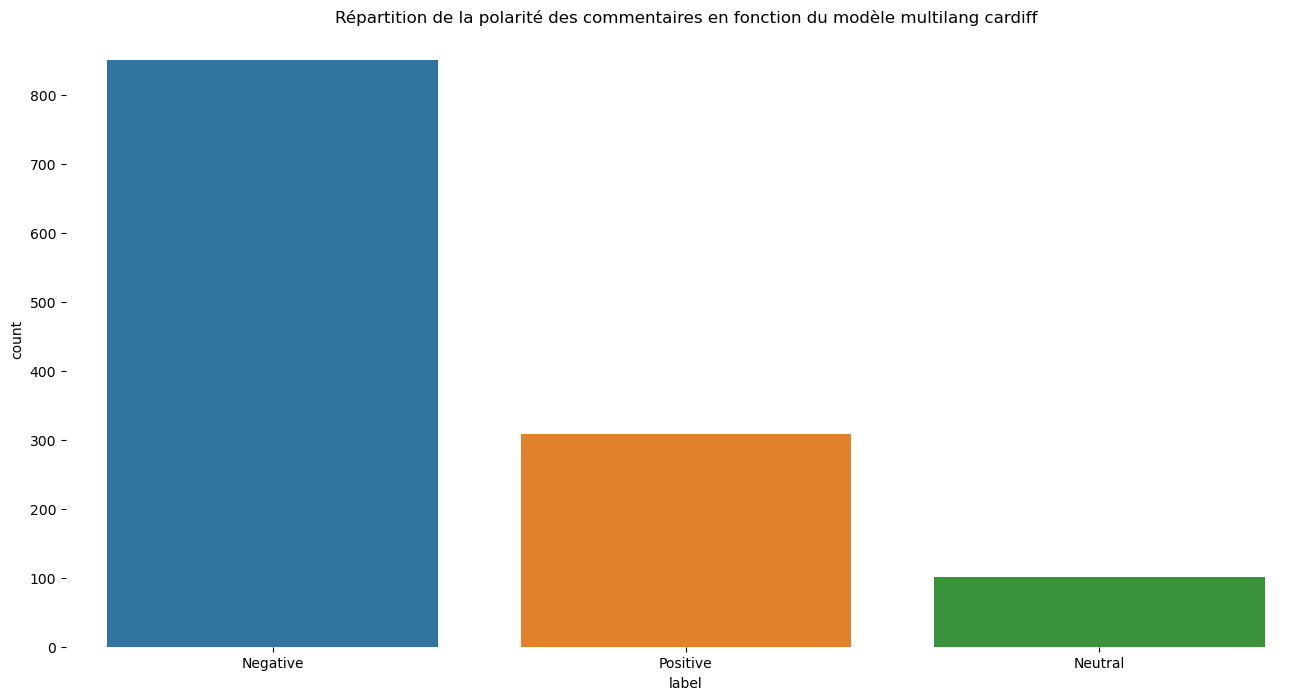

In [16]:
sns.countplot(x = sent_cardiff["label"])
plt.title("Répartition de la polarité des commentaires en fonction du modèle multilang cardiff")
plt.box(False)
plt.xlabel('label');

In [17]:
## Exploration des résultats
pd.options.display.max_colwidth = 100

In [18]:
# les cinq commentaires les plus négatifs
sent_cardiff.query("label == 'Negative'")\
            .sort_values('score')\
            .loc[lambda df: df.score > 0.95]\
            .nlargest(5, 'score')\
            .iloc[:, np.r_[0, 7:8]]

,titre,commentaires_clean
638,Préservation et valorisation d’un site classé (État et collectivités) : l’exemple de la carrière...,Un écocide patrimonial et environnemental qui rapporte de gros sous au maire de Meudon 1 million...
636,Préservation et valorisation d’un site classé (État et collectivités) : l’exemple de la carrière...,Au XXI ème siècle on détruirait encore du patrimoine exceptionnel pour bétonner ? Encore et touj...
695,SMD3 dordogne 24,Le dispositif mis en place est inefficace. Il rend les gens hostiles et bêtes.
99,Enquêter sur l’administration des données de subventions à la pêche en France,Honte absolue de l'administration qui refuse d'appliquer les décisions de justice rendues au non...
765,"Evaluation des outils de calculs des droits sociaux utilisés par les CAF (dont APL, AAH, RSA, AF)",Je suis victime de cet algorithme


In [19]:
# les cinq commentaires les plus positifs
sent_cardiff.query("label == 'Positive'")\
            .sort_values('score')\
            .loc[lambda df: df.score > 0.90]\
            .nlargest(5, 'score')\
            .iloc[:, np.r_[0, 7:8]]

,titre,commentaires_clean
53,Enquêter sur les moyens humains et financiers alloués depuis 2006 à la création d’aires marines ...,Merci encore à Bloom pour cette initiative! Pour que vive l'océan
54,Enquêter sur les moyens humains et financiers alloués depuis 2006 à la création d’aires marines ...,", Merci encore à Bloom pour cette initiative! Pour que vive l'océan"
804,Evaluer le surcoût dû à l'utilisation de logiciels propriétaires dans l'Education Nagionale,"Je plussoie, la solution EOLE est excellente et mériterait d'être diffusée partout"
1057,Maintien à l'emploi des personnes en situation de maladies chroniques ou invalidantes,Merci pour votre participation. Cela donne à réflechir
108,Enquêter sur l’administration des données de subventions à la pêche en France,Cette requête peut apporter beaucoup à la cause de la pêche durable. Merci


In [20]:
# répartition 
sent_cardiff.groupby(by =['label'])[['score']].agg([min, max, 'count', 'mean'])

score                          
               min       max count      mean
label                                       
Negative  0.346129  0.972115   851  0.687381
Neutral   0.339684  0.854504   101  0.505897
Positive  0.351257  0.951409   309  0.630668

In [21]:
(sent_cardiff.groupby(['label', pd.cut(sent_cardiff.score, bins = 10)])\
                     .size()\
                     .unstack()\
                     .T\
                     .reset_index(level = None, drop = False, inplace = False)\
                     .style.background_gradient(cmap='Pastel1')\
                     .bar(subset=["Negative"], color='#F8766D')\
                     .bar(subset=["Neutral",], color='#00BFC4')\
                     .bar(subset=["Positive",], color='#7CAE00')\
                     .set_caption('Répartition des commentaires'))

label,score,Negative,Neutral,Positive
0,"(0.339, 0.403]",48,24,31
1,"(0.403, 0.466]",104,25,42
2,"(0.466, 0.529]",90,16,40
3,"(0.529, 0.593]",85,13,34
4,"(0.593, 0.656]",59,6,21
5,"(0.656, 0.719]",68,8,36
6,"(0.719, 0.782]",69,4,26
7,"(0.782, 0.846]",70,4,27
8,"(0.846, 0.909]",86,1,31
9,"(0.909, 0.972]",172,0,21


In [22]:
sent_cardiff.groupby(by =['categorie', 'label'])[['score']].agg([min, max, 'count', 'mean'])

score  \
                                                                         min   
categorie                                                 label                
Cohésion sociale, intégration et lutte contre l’exclusion Negative  0.369842   
                                                          Neutral   0.386152   
                                                          Positive  0.364928   
Culture & communication                                   Negative  0.383645   
                                                          Neutral   0.474440   
                                                          Positive  0.430534   
Emploi & formation professionnelle                        Negative  0.427858   
                                                          Positive  0.363970   
Enseignement scolaire                                     Negative  0.401222   
                                                          Neutral   0.339684   
                                                          Positive  0.359787   
Enseignement supérieur & recherche                        Negative  0.382471   
                                                          Neutral   0.537102   
                                                          Positive  0.460076   
Environnement, agriculture et mer                         Negative  0.354388   
                                                          Neutral   0.364870   
                                                          Positive  0.351663   
Famille                                                   Negative  0.456886   
                                                          Neutral   0.367103   
                                                          Positive  0.355179   
Finances publiques & fiscalité                            Negative  0.346129   
                                                          Neutral   0.359325   
                                                          Positive  0.351257   
Handicap & dépendance                                     Negative  0.467775   
                                                          Neutral   0.854504   
                                                          Positive  0.440407   
Justice                                                   Negative  0.509158   
                                                          Neutral   0.352553   
                                                          Positive  0.708538   
Logement                                                  Negative  0.869633   
                                                          Positive  0.416498   
Non catégorisée                                           Negative  0.361335   
                                                          Neutral   0.366000   
                                                          Positive  0.377145   
Santé                                                     Negative  0.375606   
                                                          Neutral   0.409023   
                                                          Positive  0.494368   
Sécurité intérieure                                       Positive  0.701254   
Sécurité sociale                                          Negative  0.379346   
                                                          Neutral   0.381525   
                                                          Positive  0.365633   
Transports                                                Negative  0.348883   
                                                          Neutral   0.372406   
                                                          Positive  0.353092   
Économie & entreprises                                    Negative  0.371426   
                                                          Neutral   0.453797   
                                                          Positive  0.357184   
Énergie                                                   Negative  0.3

In [23]:
## Test d'un second modèle

In [9]:
# importation du modele tf-allocine pertinents, des recommandations et des annonces adaptées en fonction de votre activité passée sur ce navigateur, comme vos précédentes recherches sur Google. Le cas échéant, nous adaptons également l’expérience en fonction de l’âge de l’utilisateur à l'aide de cookies et de données.
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine")
model = TFAutoModelForSequenceClassification.from_pretrained("tblard/tf-allocine")

sentiment_task = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer)

2022-11-22 12:06:47.462680: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at tblard/tf-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


In [11]:
# application du modèle de sentiment analysis aux commentaires
sent_tf_allocine = (
    mod_data 
    .assign(sentiment = lambda x: x['commentaires'].apply(lambda s: sentiment_task(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

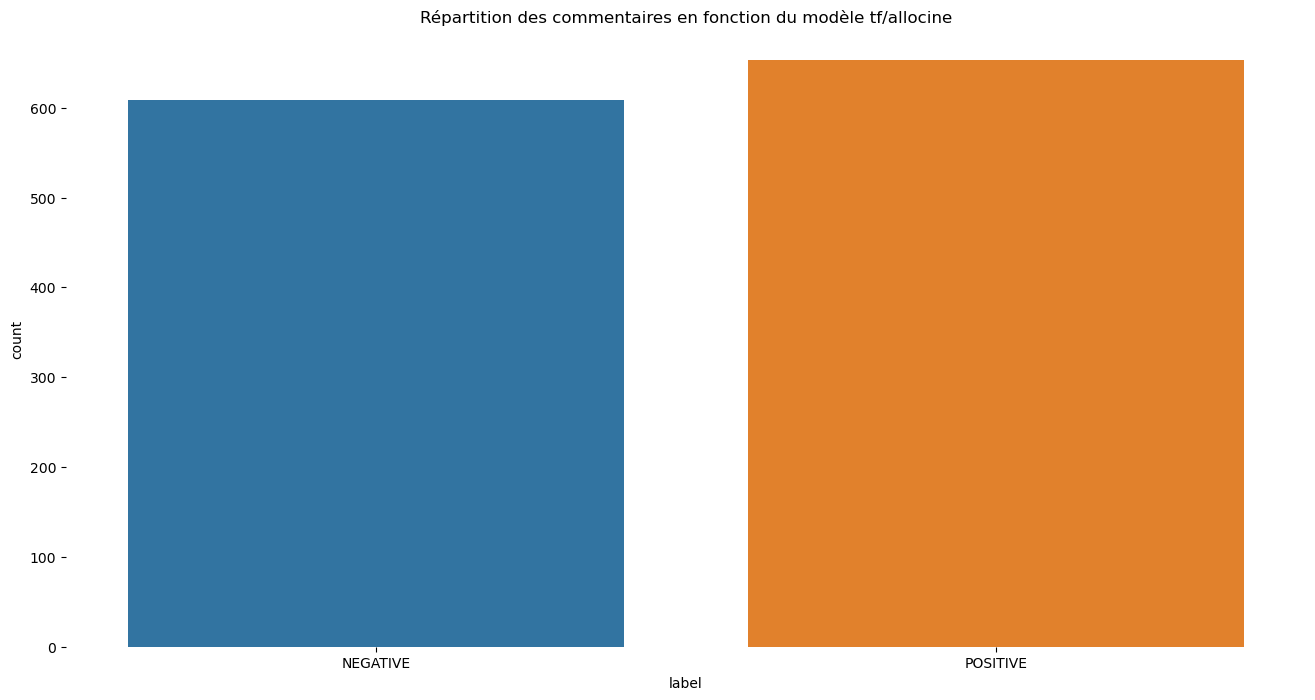

In [12]:
sns.countplot(x = sent_tf_allocine["label"])
plt.title("Répartition des commentaires en fonction du modèle tf/allocine")
plt.box(False)
plt.xlabel('label');

In [13]:
sent_tf_allocine

,titre,corps,nombre_de_commentaires,nombre_de_soutiens,nombre_abonnements,categorie,commentaires,commentaires_clean,sentiment,label,score
0,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Je partage ce point et ici on ne parle que d'u...,Je partage ce point et ici on ne parle que d'u...,"[{'label': 'NEGATIVE', 'score': 0.785757482051...",NEGATIVE,0.785757
1,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Préservons la mer qui loin de toute surveillan...,Préservons la mer qui loin de toute surveillan...,"[{'label': 'NEGATIVE', 'score': 0.648204326629...",NEGATIVE,0.648204
2,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Que l'on arrête de nous mentir !! La protectio...,Que l'on arrête de nous mentir !! La protectio...,"[{'label': 'POSITIVE', 'score': 0.916683971881...",POSITIVE,0.916684
3,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",La protection des océans doit être notre prior...,La protection des océans doit être notre prior...,"[{'label': 'POSITIVE', 'score': 0.923073232173...",POSITIVE,0.923073
4,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Il faut protéger tout ce que la terre et les o...,Il faut protéger tout ce que la terre et les o...,"[{'label': 'POSITIVE', 'score': 0.988901138305...",POSITIVE,0.988901
...,...,...,...,...,...,...,...,...,...,...,...
1364,Contrôle de l’Agence nationale des chèques vac...,Je souhaite attirer l’attention de votre insti...,1,1,3,Non catégorisée,Pour ma part je m’interroge sur tous les dispo...,Pour ma part je m’interroge sur tous les dispo...,"[{'label': 'NEGATIVE', 'score': 0.677119851112...",NEGATIVE,0.677120
1365,Remboursements Sécurité Sociale,Etudier l les remboursements (abrégés « rbt »)...,1,1,1,Sécurité sociale,supprimer automatiquement tout les dépassement...,supprimer automatiquement tout les dépassement...,"[{'label': 'NEGATIVE', 'score': 0.771494388580...",NEGATIVE,0.771494
1392,Transition electrique,vérifier la pertinence et l'efficacité des aid...,2,0,1,Non catégorisée,La transition électrique des voitures est une ...,La transition électrique des voitures est une ...,"[{'label': 'NEGATIVE', 'score': 0.986382305622...",NEGATIVE,0.986382
1393,Transition electrique,vérifier la pertinence et l'efficacité des aid...,2,0,1,Non catégorisée,Le deuxième problème est purement local lié à ...,Le deuxième problème est purement local lié à ...,"[{'label': 'NEGATIVE', 'score': 0.684093594551...",NEGATIVE,0.684094


In [14]:
# les cinq commentaires les plus négatifs
sent_tf_allocine.query("label == 'NEGATIVE'")\
            .sort_values('score')\
            .loc[lambda df: df.score > 0.90]\
            .nlargest(5, 'score')\
            .iloc[:, np.r_[0, 6, 9, 10]]

,titre,commentaires,label,score
577,Une enquête exhaustive sur la politique de la ...,Tous ces milliards qui arrosent le sable des q...,NEGATIVE,0.998850
838,Gestion et fonctionnement du Parc Naturel Régi...,Le PNR n'est vraiment plus ce qu'il était. Sa...,NEGATIVE,0.998814
1006,L'efficacité du remboursement des tests covid,Résultat nul pour une politique coûteuse.\nUn ...,NEGATIVE,0.998630
708,SMD3 dordogne 24,"Projet créé sans concertation, ignorant la pro...",NEGATIVE,0.998087
1288,Comment accélérer le retrait des voitures à mo...,Je ne pense pas que ce soit LA solution... l'é...,NEGATIVE,0.997950


In [15]:
# les cinq commentaires les plus positifs
sent_tf_allocine.query("label == 'POSITIVE'")\
            .sort_values('score')\
            .loc[lambda df: df.score > 0.90]\
            .nlargest(5, 'score')\
            .iloc[:, np.r_[0, 6, 9, 10]]

,titre,commentaires,label,score
788,Evaluation des outils de calculs des droits so...,La Cour des Comptes a déjà démontré sa capacit...,POSITIVE,0.997979
92,Enquêter sur les moyens humains et financiers ...,"Du requin-tigre au ver de terre, du pissenlit ...",POSITIVE,0.997560
591,Evaluer les dépenses de logiciels et services ...,Excellente initiative pour mieux appréhender l...,POSITIVE,0.996617
84,Enquêter sur les moyens humains et financiers ...,Des demandes comme celle-ci sont indispensable...,POSITIVE,0.996366
804,Evaluer le surcoût dû à l'utilisation de logic...,"Je plussoie, la solution EOLE est excellente e...",POSITIVE,0.995758


In [17]:
# exportation des données 
writer = pd.ExcelWriter('sent_tf_allocine.xlsx', engine = 'xlsxwriter')
sent_tf_allocine.to_excel(writer, sheet_name = 'Sheet1', index = False)
#writer.save()